In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
tf.keras.backend.clear_session()

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
subject = 'Roraima - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_RR.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Roraima - IDH,Roraima - IDH Longevidade,Roraima - Consumo de Cimento (t),Roraima- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - IDH Educacao,Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.734916,0.737579,6.920,12652.753600,2.058778,1001.077198,1671.347636,25.569094,22.736364,82.325261,1.614960,0.721714,137154.814617,6.128460e+06,332580.202821,12.101540,5.339136e+06,0.766811,8.263084,0.294583,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.734957,0.737903,7.476,12757.336292,2.058778,1001.079258,1671.347636,25.575369,22.731191,82.325261,1.615759,0.721974,138007.572103,6.136622e+06,332914.755543,12.103485,5.342057e+06,0.766348,8.257123,0.296505,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.734998,0.738226,8.659,12860.789996,2.058778,1001.080459,1671.347636,25.579030,22.728173,82.325261,1.616226,0.722235,138860.329589,6.144784e+06,333249.308265,12.105429,5.344978e+06,0.765885,8.251161,0.298178,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.735038,0.738550,7.259,12962.516425,2.058778,1001.080588,1671.347636,25.579422,22.727849,82.325261,1.616276,0.722495,139713.087075,6.152947e+06,333583.860987,12.107373,5.347899e+06,0.765422,8.245199,0.299598,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.735079,0.738873,6.786,13063.753666,2.047445,1001.066958,1673.953674,25.600512,22.700959,82.163288,1.626211,0.722756,140565.844561,6.161109e+06,333918.413709,12.109318,5.350821e+06,0.764958,8.239238,0.300965,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,38506.140515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,38458.886125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,38396.986094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,38312.397156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


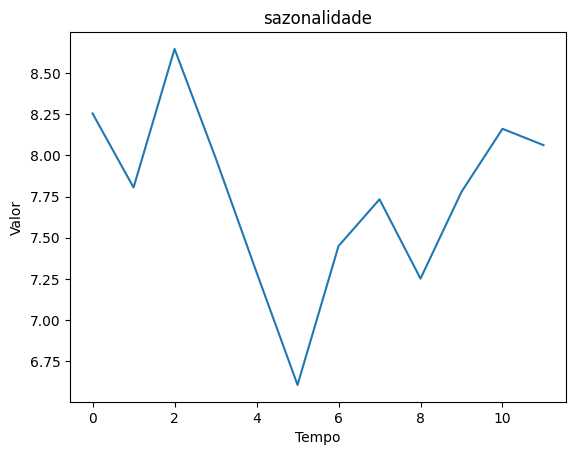

,sazonalidade
sazonalidade,
0,8.254748
1,7.805187
2,8.646925
3,7.985925
4,7.290338
5,6.606015
6,7.449672
7,7.733340
8,7.251604


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Roraima - IDH,Roraima - IDH Longevidade,Roraima- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - IDH Educacao,Roraima - Depósito Poupança (R$),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Roraima - Consumo de Cimento (t)
0,2003-1,0.734916,0.737579,12652.753600,2.058778,1001.077198,1671.347636,25.569094,22.736364,82.325261,1.614960,0.721714,137154.814617,6.128460e+06,332580.202821,12.101540,5.339136e+06,0.766811,8.263084,0.294583,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.254748,6.920
1,2003-2,0.734957,0.737903,12757.336292,2.058778,1001.079258,1671.347636,25.575369,22.731191,82.325261,1.615759,0.721974,138007.572103,6.136622e+06,332914.755543,12.103485,5.342057e+06,0.766348,8.257123,0.296505,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,7.805187,7.476
2,2003-3,0.734998,0.738226,12860.789996,2.058778,1001.080459,1671.347636,25.579030,22.728173,82.325261,1.616226,0.722235,138860.329589,6.144784e+06,333249.308265,12.105429,5.344978e+06,0.765885,8.251161,0.298178,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.646925,8.659
3,2003-4,0.735038,0.738550,12962.516425,2.058778,1001.080588,1671.347636,25.579422,22.727849,82.325261,1.616276,0.722495,139713.087075,6.152947e+06,333583.860987,12.107373,5.347899e+06,0.765422,8.245199,0.299598,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,7.985925,7.259
4,2003-5,0.735079,0.738873,13063.753666,2.047445,1001.066958,1673.953674,25.600512,22.700959,82.163288,1.626211,0.722756,140565.844561,6.161109e+06,333918.413709,12.109318,5.350821e+06,0.764958,8.239238,0.300965,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,7.290338,6.786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,38506.140515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.290338,NaN
245,2023-6,NaN,NaN,38458.886125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.606015,NaN
246,2023-7,NaN,NaN,38396.986094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.449672,NaN
247,2023-8,NaN,NaN,38312.397156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.733340,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      2.928
1      2.118
2      2.876
3      3.091
4      2.684
       ...  
244      NaN
245      NaN
246      NaN
247      NaN
248      NaN
Name: Roraima - Consumo de Cimento (t), Length: 249, dtype: float64

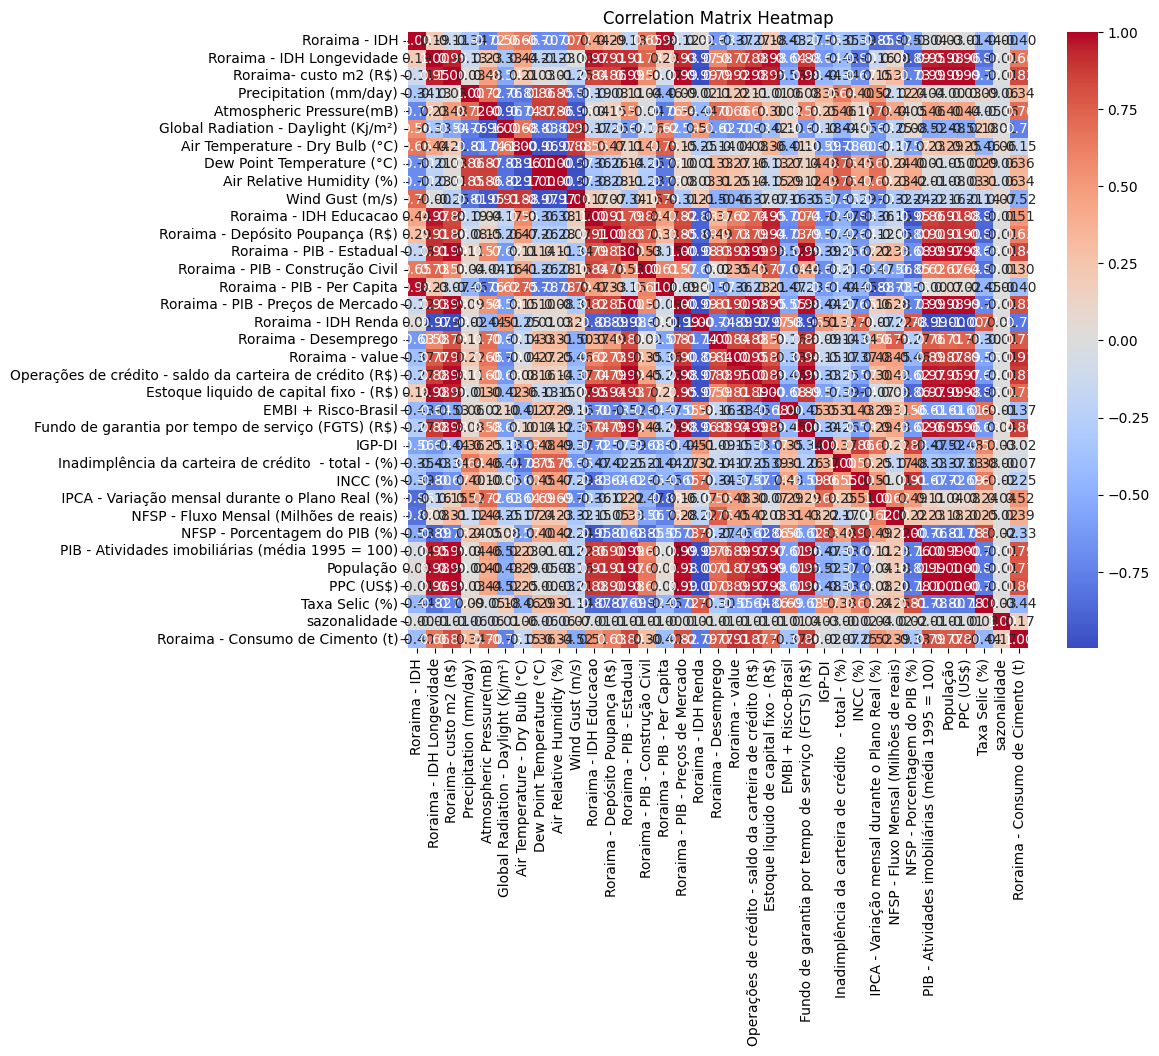

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Roraima - IDH,2.608603e+03
1,Roraima - IDH Longevidade,8.186727e+05
2,Roraima- custo m2 (R$),9.613922e+04
3,Precipitation (mm/day),3.338792e+01
4,Atmospheric Pressure(mB),4.935062e+02
5,Global Radiation - Daylight (Kj/m²),8.825775e+02
6,Air Temperature - Dry Bulb (°C),1.055130e+04
7,Dew Point Temperature (°C),2.853189e+04
8,Air Relative Humidity (%),1.164352e+05
9,Wind Gust (m/s),3.274711e+03


In [39]:
data =data.drop(['Air Temperature - Dry Bulb (°C)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 10


,Roraima- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - Depósito Poupança (R$),Roraima - PIB - Construção Civil,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,12652.753600,2.058778,1671.347636,22.736364,82.325261,1.614960,137154.814617,332580.202821,0.766811,8.263084,0.294583,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,8.254748
1,12757.336292,2.058778,1671.347636,22.731191,82.325261,1.615759,138007.572103,332914.755543,0.766348,8.257123,0.296505,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,7.805187
2,12860.789996,2.058778,1671.347636,22.728173,82.325261,1.616226,138860.329589,333249.308265,0.765885,8.251161,0.298178,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,8.646925
3,12962.516425,2.058778,1671.347636,22.727849,82.325261,1.616276,139713.087075,333583.860987,0.765422,8.245199,0.299598,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,7.985925
4,13063.753666,2.047445,1673.953674,22.700959,82.163288,1.626211,140565.844561,333918.413709,0.764958,8.239238,0.300965,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,7.290338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,23538.593975,0.098247,1627.664626,20.828874,66.269235,1.672222,417057.538454,340506.337780,0.708844,10.747295,0.412218,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,7.733340
152,23640.277238,0.206670,1644.841285,20.426315,63.270196,1.827063,412725.127924,340507.477964,0.707782,10.750656,0.412682,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,7.251604
153,23745.775204,0.204152,1629.583611,19.987376,61.092643,2.010929,408392.717394,340508.618148,0.706720,10.754017,0.413121,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,7.778761
154,23833.920559,0.426431,1598.867749,19.782537,60.218590,2.202683,404060.306864,340509.758333,0.705658,10.757378,0.413552,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,8.161704


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - Depósito Poupança (R$),Roraima - PIB - Construção Civil,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,1.151385,-0.434758,1.475362,1.501209,-1.113618,-1.727447,-2.528512,1.853148,-0.455620,-0.626316,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,1.151385,-0.434758,1.472754,1.501209,-1.112722,-1.720825,-2.449383,1.825558,-0.461718,-0.587523,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,1.151385,-0.434758,1.471233,1.501209,-1.112200,-1.714203,-2.370255,1.797968,-0.467816,-0.553773,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,1.151385,-0.434758,1.471070,1.501209,-1.112144,-1.707581,-2.291126,1.770378,-0.473914,-0.525106,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,1.138056,-0.424715,1.457514,1.489535,-1.101011,-1.700959,-2.211997,1.742787,-0.480012,-0.497524,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,-1.154454,-0.603090,0.513755,0.344018,-1.049451,0.446105,-0.653819,-1.599707,2.085460,1.747442,1.823582,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.398025,0.209123
152,-1.026936,-0.536900,0.310816,0.127871,-0.875937,0.412462,-0.653549,-1.662957,2.088898,1.756819,1.841017,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.415152,-0.182135
153,-1.029897,-0.595696,0.089538,-0.029070,-0.669897,0.378819,-0.653279,-1.726207,2.092336,1.765665,1.860456,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.432633,0.413308
154,-0.768468,-0.714059,-0.013726,-0.092065,-0.455018,0.345177,-0.653010,-1.789456,2.095774,1.774374,1.876950,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.450965,0.074029


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - Depósito Poupança (R$),Roraima - PIB - Construção Civil,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,1.151385,-0.434758,1.475362,1.501209,-1.113618,-1.727447,-2.528512,1.853148,-0.455620,-0.626316,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,1.151385,-0.434758,1.472754,1.501209,-1.112722,-1.720825,-2.449383,1.825558,-0.461718,-0.587523,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,1.151385,-0.434758,1.471233,1.501209,-1.112200,-1.714203,-2.370255,1.797968,-0.467816,-0.553773,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,1.151385,-0.434758,1.471070,1.501209,-1.112144,-1.707581,-2.291126,1.770378,-0.473914,-0.525106,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,1.138056,-0.424715,1.457514,1.489535,-1.101011,-1.700959,-2.211997,1.742787,-0.480012,-0.497524,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.700629,-0.766475,0.669365,0.580718,-1.013347,0.804571,-0.282065,-1.144125,1.892843,1.497019,1.517172,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.245801,-0.282621
140,0.116043,-0.605401,0.575118,0.439940,-0.925445,0.779978,-0.356793,-1.146692,1.926553,1.524797,1.549848,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.254608,-0.612121
141,-0.380102,-0.771665,0.449299,0.367864,-0.803724,0.755385,-0.431522,-1.149259,1.960263,1.552610,1.588878,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.263636,-0.137902
142,-0.499532,-0.748272,0.214793,0.190899,-0.615694,0.730791,-0.506250,-1.151826,1.993973,1.578374,1.625721,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.272935,-0.332143


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       2.928000
1       2.118000
2       2.876000
3       3.091000
4       2.684000
         ...    
139     9.813761
140     9.306538
141     9.861585
142    10.264788
143     9.135500
Name: Roraima - Consumo de Cimento (t), Length: 144, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 22)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - Depósito Poupança (R$),Roraima - PIB - Construção Civil,Roraima - IDH Renda,Roraima - Desemprego,Roraima - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,0.784640,-1.019067,0.505859,0.517511,-0.518095,0.662483,0.979330,-0.708085,-0.057967,0.572992,0.595959,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.812014,-1.082183
109,0.679812,-1.141890,0.588972,0.628598,-0.618130,0.727915,1.022158,-0.742845,0.018686,0.591341,0.621380,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.831569,-1.036767
110,0.508510,-1.201477,0.733043,0.769975,-0.777557,0.793347,1.064985,-0.777606,0.095340,0.611262,0.652999,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.850791,-0.752482
111,0.673244,-1.409676,0.910318,0.985006,-0.977671,0.858780,1.107812,-0.812366,0.171994,0.631151,0.685630,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.868783,-1.088413
112,0.486796,-1.469209,0.984441,1.097914,-1.100856,0.924212,1.150640,-0.847127,0.248648,0.651806,0.717515,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.886720,-1.508135
113,0.600013,-1.249417,0.998356,1.079118,-1.167613,0.989645,1.193467,-0.881887,0.325302,0.669908,0.747579,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.905151,-1.474280
114,0.923145,-1.087391,0.980928,0.993491,-1.196865,1.055077,1.236294,-0.916648,0.401956,0.695117,0.775262,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.923702,-1.463452
115,0.609526,-0.785993,0.880059,0.793569,-1.137157,1.120509,1.279122,-0.951408,0.478610,0.721079,0.805205,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.942382,-1.236037
116,0.569560,-0.623407,0.786984,0.613448,-1.035404,1.185942,1.321949,-0.986169,0.555264,0.747159,0.836796,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.960385,-0.935721
117,0.253815,-0.665689,0.563724,0.406281,-0.826447,1.251374,1.364776,-1.020929,0.631917,0.774437,0.876422,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.977769,-1.241995


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 22)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(18, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[71353789, 303705164, 3543518975, 2521593583, 3184334665, 2679136760, 150133864, 2850610640, 137478460, 2810934855]


Step: 0 ___________________________________________
val_loss: 0.6157493591308594
winner_seed: 71353789


Step: 1 ___________________________________________
val_loss: 0.8441112041473389


Step: 2 ___________________________________________
val_loss: 0.8301039934158325


Step: 3 ___________________________________________
val_loss: 0.8734087944030762


Step: 4 ___________________________________________
val_loss: 1.436556339263916


Step: 5 ___________________________________________
val_loss: 0.7900581359863281


Step: 6 ___________________________________________
val_loss: 0.5710116624832153
winner_seed: 150133864


Step: 7 ___________________________________________
val_loss: 0.8744363188743591


Step: 8 ___________________________________________
val_loss: 1.279999852180481


Step: 9 ___________________________________________
val_loss: 0.6976973414421082


final_see

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
3/3 [==============================] - 2s 199ms/step - loss: 63.9985 - val_loss: 81.6540
Epoch 2/10000
3/3 [==============================] - 0s 13ms/step - loss: 43.7009 - val_loss: 67.3961
Epoch 3/10000
3/3 [==============================] - 0s 13ms/step - loss: 31.3425 - val_loss: 54.2712
Epoch 4/10000
3/3 [==============================] - 0s 14ms/step - loss: 22.0728 - val_loss: 42.5136
Epoch 5/10000
3/3 [==============================] - 0s 15ms/step - loss: 15.2368 - val_loss: 33.1660
Epoch 6/10000
3/3 [==============================] - 0s 13ms/step - loss: 10.7541 - val_loss: 25.6228
Epoch 7/10000
3/3 [==============================] - 0s 13ms/step - loss: 7.8726 - val_loss: 19.7609
Epoch 8/10000
3/3 [==============================] - 0s 14ms/step - loss: 6.3239 - val_loss: 15.3577
Epoch 9/10000
3/3 [==============================] - 0s 14ms/step - loss: 5.3549 - val_loss: 11.6386
Epoch 10/10000
3/3 [==============================] - 0s 13ms/step - loss: 4.4195 - 

3/3 [==============================] - 0s 14ms/step - loss: 2.3537 - val_loss: 1.9182
Epoch 83/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.4567 - val_loss: 1.8581
Epoch 84/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.4021 - val_loss: 1.9418
Epoch 85/10000
3/3 [==============================] - 0s 15ms/step - loss: 2.4073 - val_loss: 1.8783
Epoch 86/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.3859 - val_loss: 1.9677
Epoch 87/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.3881 - val_loss: 1.9573
Epoch 88/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.4955 - val_loss: 1.9679
Epoch 89/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.3710 - val_loss: 1.9527
Epoch 90/10000
3/3 [==============================] - 0s 15ms/step - loss: 2.4130 - val_loss: 1.9293
Epoch 91/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.4040 - val_loss: 1.8695
Epoch

3/3 [==============================] - 0s 13ms/step - loss: 2.3090 - val_loss: 1.8983
Epoch 163/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.2350 - val_loss: 1.9289
Epoch 164/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.3400 - val_loss: 1.9826
Epoch 165/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.3323 - val_loss: 1.9733
Epoch 166/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.3410 - val_loss: 1.9338
Epoch 167/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.3508 - val_loss: 1.9263
Epoch 168/10000
3/3 [==============================] - 0s 12ms/step - loss: 2.2979 - val_loss: 1.9581
Epoch 169/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.2696 - val_loss: 1.9012
Epoch 170/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.3197 - val_loss: 1.9059
Epoch 171/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.2623 - val_loss: 1.9

3/3 [==============================] - 0s 14ms/step - loss: 2.2437 - val_loss: 2.0539
Epoch 243/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.2478 - val_loss: 2.0317
Epoch 244/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.2727 - val_loss: 2.0656
Epoch 245/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.2050 - val_loss: 2.0541
Epoch 246/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.2643 - val_loss: 2.0833
Epoch 247/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.2561 - val_loss: 2.1580
Epoch 248/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.2205 - val_loss: 2.1103
Epoch 249/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.2415 - val_loss: 2.1320
Epoch 250/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.2404 - val_loss: 2.1219
Epoch 251/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.2646 - val_loss: 2.1

3/3 [==============================] - 0s 14ms/step - loss: 2.1758 - val_loss: 2.2626
Epoch 323/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.1657 - val_loss: 2.2455
Epoch 324/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.1732 - val_loss: 2.2450
Epoch 325/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.2201 - val_loss: 2.1827
Epoch 326/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.1618 - val_loss: 2.2489
Epoch 327/10000
3/3 [==============================] - 0s 12ms/step - loss: 2.2008 - val_loss: 2.2458
Epoch 328/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.1640 - val_loss: 2.2846
Epoch 329/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.2088 - val_loss: 2.2984
Epoch 330/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.2353 - val_loss: 2.2419
Epoch 331/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.1904 - val_loss: 2.2

3/3 [==============================] - 0s 14ms/step - loss: 2.1040 - val_loss: 2.3354
Epoch 403/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.1935 - val_loss: 2.3768
Epoch 404/10000
3/3 [==============================] - 0s 15ms/step - loss: 2.1304 - val_loss: 2.3269
Epoch 405/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.1265 - val_loss: 2.3236
Epoch 406/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.0800 - val_loss: 2.3323
Epoch 407/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.1794 - val_loss: 2.2557
Epoch 408/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.1293 - val_loss: 2.2791
Epoch 409/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.1321 - val_loss: 2.2519
Epoch 410/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.1160 - val_loss: 2.2573
Epoch 411/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.2309 - val_loss: 2.3

3/3 [==============================] - 0s 14ms/step - loss: 2.1074 - val_loss: 2.6471
Epoch 483/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.1198 - val_loss: 2.5818
Epoch 484/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.0494 - val_loss: 2.5704
Epoch 485/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.0653 - val_loss: 2.5515
Epoch 486/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.0583 - val_loss: 2.5932
Epoch 487/10000
3/3 [==============================] - 0s 12ms/step - loss: 2.0567 - val_loss: 2.6225
Epoch 488/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.0141 - val_loss: 2.5769
Epoch 489/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.0631 - val_loss: 2.6370
Epoch 490/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.0996 - val_loss: 2.6212
Epoch 491/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.0694 - val_loss: 2.6

3/3 [==============================] - 0s 14ms/step - loss: 2.0221 - val_loss: 2.6480
Epoch 563/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.9977 - val_loss: 2.6436
Epoch 564/10000
3/3 [==============================] - 0s 13ms/step - loss: 2.0249 - val_loss: 2.6563
Epoch 565/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.0332 - val_loss: 2.6849
Epoch 566/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.9997 - val_loss: 2.7373
Epoch 567/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.0705 - val_loss: 2.8188
Epoch 568/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.0471 - val_loss: 2.7389
Epoch 569/10000
3/3 [==============================] - 0s 16ms/step - loss: 2.0405 - val_loss: 2.6880
Epoch 570/10000
3/3 [==============================] - 0s 14ms/step - loss: 2.0127 - val_loss: 2.7377
Epoch 571/10000
3/3 [==============================] - 0s 15ms/step - loss: 2.0830 - val_loss: 2.7

3/3 [==============================] - 0s 13ms/step - loss: 1.9727 - val_loss: 2.8310
Epoch 643/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.9882 - val_loss: 2.8471
Epoch 644/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.9518 - val_loss: 3.0578
Epoch 645/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.9921 - val_loss: 2.9913
Epoch 646/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.9551 - val_loss: 2.9827
Epoch 647/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.8835 - val_loss: 2.9215
Epoch 648/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.9849 - val_loss: 3.0020
Epoch 649/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.9185 - val_loss: 2.9471
Epoch 650/10000
3/3 [==============================] - 0s 12ms/step - loss: 1.8819 - val_loss: 2.7759
Epoch 651/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.9659 - val_loss: 2.7

3/3 [==============================] - 0s 14ms/step - loss: 1.9152 - val_loss: 2.6143
Epoch 723/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.8922 - val_loss: 2.5433
Epoch 724/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.9072 - val_loss: 2.6541
Epoch 725/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.8496 - val_loss: 2.7159
Epoch 726/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.9173 - val_loss: 2.7902
Epoch 727/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.9329 - val_loss: 2.6405
Epoch 728/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.8717 - val_loss: 2.7283
Epoch 729/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.9207 - val_loss: 2.7050
Epoch 730/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.8884 - val_loss: 2.6465
Epoch 731/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.8740 - val_loss: 2.4

3/3 [==============================] - 0s 13ms/step - loss: 1.9551 - val_loss: 2.8609
Epoch 803/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.8923 - val_loss: 2.6583
Epoch 804/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.8094 - val_loss: 2.7977
Epoch 805/10000
3/3 [==============================] - 0s 12ms/step - loss: 1.8500 - val_loss: 2.9178
Epoch 806/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.8388 - val_loss: 2.8824
Epoch 807/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.8967 - val_loss: 2.8895
Epoch 808/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.7839 - val_loss: 3.0414
Epoch 809/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.7890 - val_loss: 2.8242
Epoch 810/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.9475 - val_loss: 2.8763
Epoch 811/10000
3/3 [==============================] - 0s 12ms/step - loss: 1.8617 - val_loss: 2.9

3/3 [==============================] - 0s 14ms/step - loss: 1.7272 - val_loss: 2.7548
Epoch 883/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.8143 - val_loss: 2.9922
Epoch 884/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.7857 - val_loss: 2.9956
Epoch 885/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.7858 - val_loss: 2.8354
Epoch 886/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.8189 - val_loss: 2.9286
Epoch 887/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.7848 - val_loss: 2.9726
Epoch 888/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.7656 - val_loss: 3.0732
Epoch 889/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.7804 - val_loss: 2.8748
Epoch 890/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.7688 - val_loss: 2.6987
Epoch 891/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.7340 - val_loss: 2.8

3/3 [==============================] - 0s 16ms/step - loss: 1.6641 - val_loss: 2.4078
Epoch 963/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.7595 - val_loss: 2.6536
Epoch 964/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.7264 - val_loss: 2.6262
Epoch 965/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.6946 - val_loss: 2.8496
Epoch 966/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.6681 - val_loss: 2.7438
Epoch 967/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.6662 - val_loss: 2.6222
Epoch 968/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.6683 - val_loss: 2.7000
Epoch 969/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.6670 - val_loss: 2.6006
Epoch 970/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.6467 - val_loss: 2.5114
Epoch 971/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.6858 - val_loss: 2.5

3/3 [==============================] - 0s 14ms/step - loss: 1.6957 - val_loss: 2.2520
Epoch 1043/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.7129 - val_loss: 2.2705
Epoch 1044/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.6892 - val_loss: 2.4472
Epoch 1045/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.5846 - val_loss: 2.4411
Epoch 1046/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.6164 - val_loss: 2.2562
Epoch 1047/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.6167 - val_loss: 2.1578
Epoch 1048/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.5838 - val_loss: 2.1895
Epoch 1049/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.6181 - val_loss: 2.2449
Epoch 1050/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.5609 - val_loss: 2.2383
Epoch 1051/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.5378 - val_

3/3 [==============================] - 0s 16ms/step - loss: 1.5315 - val_loss: 1.8057
Epoch 1122/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.6167 - val_loss: 2.0534
Epoch 1123/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.5633 - val_loss: 2.0023
Epoch 1124/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.5658 - val_loss: 1.9463
Epoch 1125/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.4769 - val_loss: 2.0084
Epoch 1126/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.5595 - val_loss: 2.0492
Epoch 1127/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.6365 - val_loss: 1.9272
Epoch 1128/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.5569 - val_loss: 1.8947
Epoch 1129/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.4900 - val_loss: 2.0053
Epoch 1130/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.5516 - val_

3/3 [==============================] - 0s 16ms/step - loss: 1.4445 - val_loss: 1.7104
Epoch 1201/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.5987 - val_loss: 1.5224
Epoch 1202/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.5565 - val_loss: 1.6107
Epoch 1203/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.7043 - val_loss: 1.5962
Epoch 1204/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.5233 - val_loss: 1.4653
Epoch 1205/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.5454 - val_loss: 1.6959
Epoch 1206/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.4413 - val_loss: 1.5293
Epoch 1207/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.4303 - val_loss: 1.6049
Epoch 1208/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.4581 - val_loss: 1.5753
Epoch 1209/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.4616 - val_

3/3 [==============================] - 0s 17ms/step - loss: 1.4725 - val_loss: 1.3636
Epoch 1280/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.4751 - val_loss: 1.2589
Epoch 1281/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.4516 - val_loss: 1.3970
Epoch 1282/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.4612 - val_loss: 1.2984
Epoch 1283/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.4343 - val_loss: 1.3216
Epoch 1284/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.4779 - val_loss: 1.2249
Epoch 1285/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.3874 - val_loss: 1.2084
Epoch 1286/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.4400 - val_loss: 1.3284
Epoch 1287/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.4306 - val_loss: 1.3079
Epoch 1288/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.3849 - val_

3/3 [==============================] - 0s 15ms/step - loss: 1.3857 - val_loss: 1.0900
Epoch 1359/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.3716 - val_loss: 1.1304
Epoch 1360/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.3754 - val_loss: 1.1087
Epoch 1361/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.4328 - val_loss: 1.1061
Epoch 1362/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.3817 - val_loss: 1.0967
Epoch 1363/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.3498 - val_loss: 1.0966
Epoch 1364/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.3885 - val_loss: 1.1772
Epoch 1365/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.4480 - val_loss: 1.2237
Epoch 1366/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.3704 - val_loss: 1.1703
Epoch 1367/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.4609 - val_

3/3 [==============================] - 0s 16ms/step - loss: 1.2919 - val_loss: 1.0975
Epoch 1438/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.3925 - val_loss: 1.0908
Epoch 1439/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.4268 - val_loss: 1.1125
Epoch 1440/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.4899 - val_loss: 1.0341
Epoch 1441/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.3826 - val_loss: 1.0639
Epoch 1442/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.3399 - val_loss: 1.0295
Epoch 1443/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.3557 - val_loss: 0.9868
Epoch 1444/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.3936 - val_loss: 1.0711
Epoch 1445/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.3214 - val_loss: 1.0162
Epoch 1446/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.3614 - val_

3/3 [==============================] - 0s 16ms/step - loss: 1.3591 - val_loss: 0.9848
Epoch 1517/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.3017 - val_loss: 0.9611
Epoch 1518/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.3150 - val_loss: 1.0018
Epoch 1519/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.2778 - val_loss: 0.9770
Epoch 1520/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.3191 - val_loss: 0.9592
Epoch 1521/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.3401 - val_loss: 1.0222
Epoch 1522/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.3157 - val_loss: 0.9662
Epoch 1523/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.3961 - val_loss: 0.9873
Epoch 1524/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.2992 - val_loss: 0.9842
Epoch 1525/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.2479 - val_

3/3 [==============================] - 0s 15ms/step - loss: 1.1915 - val_loss: 0.9093
Epoch 1596/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.2495 - val_loss: 0.9513
Epoch 1597/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.2661 - val_loss: 0.9422
Epoch 1598/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.3025 - val_loss: 0.9623
Epoch 1599/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.2073 - val_loss: 0.8945
Epoch 1600/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.2771 - val_loss: 0.9227
Epoch 1601/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.2569 - val_loss: 0.9285
Epoch 1602/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.2950 - val_loss: 0.9239
Epoch 1603/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.2162 - val_loss: 0.8745
Epoch 1604/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.2819 - val_

3/3 [==============================] - 0s 16ms/step - loss: 1.1516 - val_loss: 0.8919
Epoch 1675/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.2762 - val_loss: 0.8820
Epoch 1676/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.2463 - val_loss: 0.8237
Epoch 1677/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.2233 - val_loss: 0.8315
Epoch 1678/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.2458 - val_loss: 0.8296
Epoch 1679/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.2649 - val_loss: 0.8148
Epoch 1680/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.2076 - val_loss: 0.8727
Epoch 1681/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.2111 - val_loss: 0.8734
Epoch 1682/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.2588 - val_loss: 0.8502
Epoch 1683/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.2398 - val_

3/3 [==============================] - 0s 14ms/step - loss: 1.1165 - val_loss: 0.8259
Epoch 1754/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.2004 - val_loss: 0.8240
Epoch 1755/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.2262 - val_loss: 0.8183
Epoch 1756/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.1616 - val_loss: 0.8201
Epoch 1757/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.1967 - val_loss: 0.8268
Epoch 1758/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.1868 - val_loss: 0.8117
Epoch 1759/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.1811 - val_loss: 0.8961
Epoch 1760/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.2147 - val_loss: 0.8322
Epoch 1761/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.2081 - val_loss: 0.8234
Epoch 1762/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.1787 - val_

3/3 [==============================] - 0s 15ms/step - loss: 1.2499 - val_loss: 0.8106
Epoch 1833/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.1259 - val_loss: 0.8022
Epoch 1834/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.1638 - val_loss: 0.8026
Epoch 1835/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.1348 - val_loss: 0.8024
Epoch 1836/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.2485 - val_loss: 0.8000
Epoch 1837/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.1220 - val_loss: 0.7998
Epoch 1838/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.1782 - val_loss: 0.8022
Epoch 1839/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.1602 - val_loss: 0.8054
Epoch 1840/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.1451 - val_loss: 0.8131
Epoch 1841/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.1053 - val_

3/3 [==============================] - 0s 15ms/step - loss: 1.0801 - val_loss: 0.8070
Epoch 1912/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.1242 - val_loss: 0.7985
Epoch 1913/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.0364 - val_loss: 0.7974
Epoch 1914/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.0956 - val_loss: 0.7970
Epoch 1915/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.0297 - val_loss: 0.7955
Epoch 1916/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.1237 - val_loss: 0.8037
Epoch 1917/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.1961 - val_loss: 0.7974
Epoch 1918/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.0873 - val_loss: 0.7984
Epoch 1919/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.1762 - val_loss: 0.7953
Epoch 1920/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.0308 - val_

3/3 [==============================] - 0s 13ms/step - loss: 1.0749 - val_loss: 0.7928
Epoch 1991/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.9972 - val_loss: 0.7936
Epoch 1992/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.0636 - val_loss: 0.7930
Epoch 1993/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.0240 - val_loss: 0.7882
Epoch 1994/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.0238 - val_loss: 0.7926
Epoch 1995/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.0614 - val_loss: 0.7909
Epoch 1996/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.9769 - val_loss: 0.7894
Epoch 1997/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.0385 - val_loss: 0.7878
Epoch 1998/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.0433 - val_loss: 0.7920
Epoch 1999/10000
3/3 [==============================] - 0s 13ms/step - loss: 1.0697 - val_

3/3 [==============================] - 0s 17ms/step - loss: 1.0977 - val_loss: 0.7775
Epoch 2070/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.0718 - val_loss: 0.7911
Epoch 2071/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9961 - val_loss: 0.7927
Epoch 2072/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.0616 - val_loss: 0.7835
Epoch 2073/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.9948 - val_loss: 0.7858
Epoch 2074/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9889 - val_loss: 0.7852
Epoch 2075/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.0099 - val_loss: 0.7927
Epoch 2076/10000
3/3 [==============================] - 0s 15ms/step - loss: 1.0331 - val_loss: 0.7916
Epoch 2077/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.9599 - val_loss: 0.7909
Epoch 2078/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.0665 - val_

3/3 [==============================] - 0s 18ms/step - loss: 1.0318 - val_loss: 0.7809
Epoch 2149/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.9621 - val_loss: 0.7799
Epoch 2150/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.0286 - val_loss: 0.7889
Epoch 2151/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.9929 - val_loss: 0.7828
Epoch 2152/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9781 - val_loss: 0.7695
Epoch 2153/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.9305 - val_loss: 0.7769
Epoch 2154/10000
3/3 [==============================] - 0s 18ms/step - loss: 1.0146 - val_loss: 0.7790
Epoch 2155/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.9349 - val_loss: 0.7937
Epoch 2156/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.9406 - val_loss: 0.7931
Epoch 2157/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.9862 - val_

3/3 [==============================] - 0s 14ms/step - loss: 0.9052 - val_loss: 0.7785
Epoch 2228/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9664 - val_loss: 0.7735
Epoch 2229/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.8974 - val_loss: 0.7640
Epoch 2230/10000
3/3 [==============================] - 0s 19ms/step - loss: 1.0465 - val_loss: 0.7588
Epoch 2231/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.9047 - val_loss: 0.7600
Epoch 2232/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9335 - val_loss: 0.7684
Epoch 2233/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.8608 - val_loss: 0.7741
Epoch 2234/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.9104 - val_loss: 0.7703
Epoch 2235/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9952 - val_loss: 0.7653
Epoch 2236/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.8982 - val_

3/3 [==============================] - 0s 16ms/step - loss: 0.9394 - val_loss: 0.7628
Epoch 2307/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.8788 - val_loss: 0.7824
Epoch 2308/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9189 - val_loss: 0.7632
Epoch 2309/10000
3/3 [==============================] - 0s 17ms/step - loss: 1.0133 - val_loss: 0.7786
Epoch 2310/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.9521 - val_loss: 0.7711
Epoch 2311/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.8653 - val_loss: 0.7688
Epoch 2312/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9547 - val_loss: 0.7671
Epoch 2313/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.8541 - val_loss: 0.7745
Epoch 2314/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.8878 - val_loss: 0.7744
Epoch 2315/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9398 - val_

3/3 [==============================] - 0s 18ms/step - loss: 0.9245 - val_loss: 0.7768
Epoch 2386/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.9006 - val_loss: 0.7684
Epoch 2387/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9334 - val_loss: 0.7830
Epoch 2388/10000
3/3 [==============================] - 0s 18ms/step - loss: 0.8966 - val_loss: 0.7771
Epoch 2389/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.8779 - val_loss: 0.7566
Epoch 2390/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.8570 - val_loss: 0.7691
Epoch 2391/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.8776 - val_loss: 0.7684
Epoch 2392/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.9294 - val_loss: 0.7786
Epoch 2393/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.8549 - val_loss: 0.7736
Epoch 2394/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9078 - val_

3/3 [==============================] - 0s 15ms/step - loss: 0.9388 - val_loss: 0.7762
Epoch 2465/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9523 - val_loss: 0.7588
Epoch 2466/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.9202 - val_loss: 0.7586
Epoch 2467/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.9226 - val_loss: 0.7489
Epoch 2468/10000
3/3 [==============================] - 0s 16ms/step - loss: 1.0959 - val_loss: 0.7600
Epoch 2469/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.8047 - val_loss: 0.7522
Epoch 2470/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9057 - val_loss: 0.7394
Epoch 2471/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.9156 - val_loss: 0.7550
Epoch 2472/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.8801 - val_loss: 0.7801
Epoch 2473/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.8633 - val_

3/3 [==============================] - 0s 16ms/step - loss: 0.8322 - val_loss: 0.7503
Epoch 2544/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7984 - val_loss: 0.7679
Epoch 2545/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.9284 - val_loss: 0.7416
Epoch 2546/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.8644 - val_loss: 0.7539
Epoch 2547/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.8256 - val_loss: 0.7487
Epoch 2548/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.8756 - val_loss: 0.7347
Epoch 2549/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.8535 - val_loss: 0.7469
Epoch 2550/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.8182 - val_loss: 0.7419
Epoch 2551/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.8693 - val_loss: 0.7317
Epoch 2552/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.8451 - val_

3/3 [==============================] - 0s 13ms/step - loss: 1.2959 - val_loss: 0.7326
Epoch 2623/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.9209 - val_loss: 0.7302
Epoch 2624/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.8750 - val_loss: 0.7445
Epoch 2625/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.8394 - val_loss: 0.7447
Epoch 2626/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.8578 - val_loss: 0.7554
Epoch 2627/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.8598 - val_loss: 0.7385
Epoch 2628/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.8625 - val_loss: 0.7448
Epoch 2629/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.8495 - val_loss: 0.7247
Epoch 2630/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.8764 - val_loss: 0.7170
Epoch 2631/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.8373 - val_

3/3 [==============================] - 0s 14ms/step - loss: 0.7818 - val_loss: 0.7235
Epoch 2702/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7853 - val_loss: 0.7173
Epoch 2703/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.8246 - val_loss: 0.7300
Epoch 2704/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7676 - val_loss: 0.7194
Epoch 2705/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.8178 - val_loss: 0.7090
Epoch 2706/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.8328 - val_loss: 0.7134
Epoch 2707/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.7845 - val_loss: 0.7254
Epoch 2708/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7707 - val_loss: 0.7354
Epoch 2709/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7667 - val_loss: 0.7213
Epoch 2710/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.8481 - val_

3/3 [==============================] - 0s 14ms/step - loss: 0.8416 - val_loss: 0.7025
Epoch 2781/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.8134 - val_loss: 0.7285
Epoch 2782/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.8242 - val_loss: 0.7336
Epoch 2783/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7788 - val_loss: 0.7186
Epoch 2784/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7909 - val_loss: 0.7151
Epoch 2785/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7651 - val_loss: 0.7048
Epoch 2786/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7664 - val_loss: 0.7238
Epoch 2787/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7887 - val_loss: 0.7091
Epoch 2788/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.9007 - val_loss: 0.7149
Epoch 2789/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7814 - val_

3/3 [==============================] - 0s 14ms/step - loss: 0.8391 - val_loss: 0.7070
Epoch 2860/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7407 - val_loss: 0.7031
Epoch 2861/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7818 - val_loss: 0.7029
Epoch 2862/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.8168 - val_loss: 0.6943
Epoch 2863/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.7649 - val_loss: 0.7223
Epoch 2864/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7813 - val_loss: 0.6876
Epoch 2865/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7915 - val_loss: 0.7260
Epoch 2866/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.8061 - val_loss: 0.7275
Epoch 2867/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7853 - val_loss: 0.6949
Epoch 2868/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.7633 - val_

3/3 [==============================] - 0s 15ms/step - loss: 0.7114 - val_loss: 0.6673
Epoch 2939/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7240 - val_loss: 0.6732
Epoch 2940/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7479 - val_loss: 0.6837
Epoch 2941/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6926 - val_loss: 0.6723
Epoch 2942/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7477 - val_loss: 0.6978
Epoch 2943/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.7714 - val_loss: 0.6791
Epoch 2944/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.7520 - val_loss: 0.7008
Epoch 2945/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7745 - val_loss: 0.6869
Epoch 2946/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.8056 - val_loss: 0.6846
Epoch 2947/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7836 - val_

3/3 [==============================] - 0s 14ms/step - loss: 0.7380 - val_loss: 0.6826
Epoch 3018/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.7885 - val_loss: 0.6767
Epoch 3019/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7262 - val_loss: 0.6726
Epoch 3020/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.7984 - val_loss: 0.6757
Epoch 3021/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7727 - val_loss: 0.6732
Epoch 3022/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.7169 - val_loss: 0.6743
Epoch 3023/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6822 - val_loss: 0.6633
Epoch 3024/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7653 - val_loss: 0.6699
Epoch 3025/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7868 - val_loss: 0.6735
Epoch 3026/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7999 - val_

3/3 [==============================] - 0s 13ms/step - loss: 0.7186 - val_loss: 0.6805
Epoch 3097/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7216 - val_loss: 0.6524
Epoch 3098/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7484 - val_loss: 0.6561
Epoch 3099/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7229 - val_loss: 0.6901
Epoch 3100/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6862 - val_loss: 0.6651
Epoch 3101/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.7262 - val_loss: 0.6486
Epoch 3102/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7281 - val_loss: 0.6723
Epoch 3103/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7788 - val_loss: 0.6617
Epoch 3104/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7970 - val_loss: 0.7136
Epoch 3105/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7892 - val_

3/3 [==============================] - 0s 14ms/step - loss: 0.7607 - val_loss: 0.6418
Epoch 3176/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7542 - val_loss: 0.6659
Epoch 3177/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6781 - val_loss: 0.6609
Epoch 3178/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.7573 - val_loss: 0.6393
Epoch 3179/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.8173 - val_loss: 0.6546
Epoch 3180/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6728 - val_loss: 0.6607
Epoch 3181/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7888 - val_loss: 0.6733
Epoch 3182/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7447 - val_loss: 0.6903
Epoch 3183/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.7696 - val_loss: 0.6649
Epoch 3184/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6966 - val_

3/3 [==============================] - 0s 14ms/step - loss: 0.7312 - val_loss: 0.6458
Epoch 3255/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7576 - val_loss: 0.6406
Epoch 3256/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.7543 - val_loss: 0.6416
Epoch 3257/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.9310 - val_loss: 0.6369
Epoch 3258/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7334 - val_loss: 0.6336
Epoch 3259/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6854 - val_loss: 0.6584
Epoch 3260/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6801 - val_loss: 0.6499
Epoch 3261/10000
3/3 [==============================] - 0s 14ms/step - loss: 1.3090 - val_loss: 0.6145
Epoch 3262/10000
3/3 [==============================] - 0s 17ms/step - loss: 0.8395 - val_loss: 0.6300
Epoch 3263/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7127 - val_

3/3 [==============================] - 0s 11ms/step - loss: 0.7524 - val_loss: 0.6488
Epoch 3334/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.7134 - val_loss: 0.6412
Epoch 3335/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6934 - val_loss: 0.6626
Epoch 3336/10000
3/3 [==============================] - 0s 11ms/step - loss: 0.8804 - val_loss: 0.6234
Epoch 3337/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6484 - val_loss: 0.6456
Epoch 3338/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7007 - val_loss: 0.6496
Epoch 3339/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6947 - val_loss: 0.6457
Epoch 3340/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6721 - val_loss: 0.6347
Epoch 3341/10000
3/3 [==============================] - 0s 11ms/step - loss: 0.7207 - val_loss: 0.6455
Epoch 3342/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.6787 - val_

3/3 [==============================] - 0s 13ms/step - loss: 0.6637 - val_loss: 0.6483
Epoch 3413/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6919 - val_loss: 0.6261
Epoch 3414/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6613 - val_loss: 0.6142
Epoch 3415/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7386 - val_loss: 0.6226
Epoch 3416/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6661 - val_loss: 0.6398
Epoch 3417/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6913 - val_loss: 0.6370
Epoch 3418/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.7261 - val_loss: 0.6488
Epoch 3419/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6438 - val_loss: 0.6274
Epoch 3420/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6364 - val_loss: 0.6088
Epoch 3421/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6938 - val_

3/3 [==============================] - 0s 14ms/step - loss: 0.6796 - val_loss: 0.6322
Epoch 3492/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.6682 - val_loss: 0.6251
Epoch 3493/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.7335 - val_loss: 0.6322
Epoch 3494/10000
3/3 [==============================] - 0s 11ms/step - loss: 0.7003 - val_loss: 0.6349
Epoch 3495/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.6642 - val_loss: 0.6252
Epoch 3496/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.6291 - val_loss: 0.6544
Epoch 3497/10000
3/3 [==============================] - 0s 11ms/step - loss: 0.6782 - val_loss: 0.6259
Epoch 3498/10000
3/3 [==============================] - 0s 11ms/step - loss: 0.6660 - val_loss: 0.6245
Epoch 3499/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.6381 - val_loss: 0.6292
Epoch 3500/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.6877 - val_

3/3 [==============================] - 0s 13ms/step - loss: 0.7313 - val_loss: 0.6312
Epoch 3571/10000
3/3 [==============================] - 0s 16ms/step - loss: 0.6810 - val_loss: 0.6274
Epoch 3572/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6138 - val_loss: 0.6311
Epoch 3573/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6329 - val_loss: 0.6188
Epoch 3574/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6051 - val_loss: 0.6126
Epoch 3575/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5665 - val_loss: 0.6187
Epoch 3576/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6628 - val_loss: 0.6149
Epoch 3577/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6580 - val_loss: 0.6130
Epoch 3578/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6047 - val_loss: 0.6360
Epoch 3579/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6652 - val_

3/3 [==============================] - 0s 13ms/step - loss: 0.6145 - val_loss: 0.6171
Epoch 3650/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6395 - val_loss: 0.6083
Epoch 3651/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6276 - val_loss: 0.6151
Epoch 3652/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6189 - val_loss: 0.6114
Epoch 3653/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5841 - val_loss: 0.6143
Epoch 3654/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6229 - val_loss: 0.6319
Epoch 3655/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6636 - val_loss: 0.6256
Epoch 3656/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6563 - val_loss: 0.6276
Epoch 3657/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.6043 - val_loss: 0.6219
Epoch 3658/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7423 - val_

3/3 [==============================] - 0s 13ms/step - loss: 0.6841 - val_loss: 0.6107
Epoch 3729/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6534 - val_loss: 0.6195
Epoch 3730/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6727 - val_loss: 0.6226
Epoch 3731/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6255 - val_loss: 0.6081
Epoch 3732/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6218 - val_loss: 0.6185
Epoch 3733/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6342 - val_loss: 0.6085
Epoch 3734/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6009 - val_loss: 0.6086
Epoch 3735/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6443 - val_loss: 0.6107
Epoch 3736/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6165 - val_loss: 0.6193
Epoch 3737/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6412 - val_

3/3 [==============================] - 0s 14ms/step - loss: 0.6254 - val_loss: 0.5889
Epoch 3808/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.6312 - val_loss: 0.5960
Epoch 3809/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6759 - val_loss: 0.5979
Epoch 3810/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6785 - val_loss: 0.6123
Epoch 3811/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.7511 - val_loss: 0.6278
Epoch 3812/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6343 - val_loss: 0.6071
Epoch 3813/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6406 - val_loss: 0.6191
Epoch 3814/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5404 - val_loss: 0.6307
Epoch 3815/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.5933 - val_loss: 0.6430
Epoch 3816/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5957 - val_

3/3 [==============================] - 0s 13ms/step - loss: 0.6245 - val_loss: 0.6248
Epoch 3887/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5970 - val_loss: 0.6455
Epoch 3888/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6277 - val_loss: 0.6374
Epoch 3889/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5898 - val_loss: 0.6243
Epoch 3890/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6158 - val_loss: 0.6266
Epoch 3891/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5633 - val_loss: 0.6386
Epoch 3892/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6178 - val_loss: 0.6308
Epoch 3893/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6133 - val_loss: 0.6186
Epoch 3894/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.5799 - val_loss: 0.6192
Epoch 3895/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6457 - val_

3/3 [==============================] - 0s 13ms/step - loss: 0.5838 - val_loss: 0.6158
Epoch 3966/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5679 - val_loss: 0.5962
Epoch 3967/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6249 - val_loss: 0.6054
Epoch 3968/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5170 - val_loss: 0.6179
Epoch 3969/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5531 - val_loss: 0.6206
Epoch 3970/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5552 - val_loss: 0.6258
Epoch 3971/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5646 - val_loss: 0.6224
Epoch 3972/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5535 - val_loss: 0.6226
Epoch 3973/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6095 - val_loss: 0.5931
Epoch 3974/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5906 - val_

3/3 [==============================] - 0s 13ms/step - loss: 0.5885 - val_loss: 0.6177
Epoch 4045/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5317 - val_loss: 0.6177
Epoch 4046/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5744 - val_loss: 0.6197
Epoch 4047/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5631 - val_loss: 0.6069
Epoch 4048/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5562 - val_loss: 0.6127
Epoch 4049/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6002 - val_loss: 0.5970
Epoch 4050/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5993 - val_loss: 0.6230
Epoch 4051/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6508 - val_loss: 0.6190
Epoch 4052/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5979 - val_loss: 0.6496
Epoch 4053/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.8014 - val_

3/3 [==============================] - 0s 18ms/step - loss: 1.0899 - val_loss: 0.6362
Epoch 4124/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5991 - val_loss: 0.6373
Epoch 4125/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5356 - val_loss: 0.6136
Epoch 4126/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6098 - val_loss: 0.6213
Epoch 4127/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5646 - val_loss: 0.6090
Epoch 4128/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5417 - val_loss: 0.5954
Epoch 4129/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6637 - val_loss: 0.6179
Epoch 4130/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6318 - val_loss: 0.6125
Epoch 4131/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6095 - val_loss: 0.6024
Epoch 4132/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6950 - val_

3/3 [==============================] - 0s 14ms/step - loss: 0.5236 - val_loss: 0.5968
Epoch 4203/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.4948 - val_loss: 0.6017
Epoch 4204/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5713 - val_loss: 0.6247
Epoch 4205/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6008 - val_loss: 0.6070
Epoch 4206/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5347 - val_loss: 0.5989
Epoch 4207/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5926 - val_loss: 0.6125
Epoch 4208/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5290 - val_loss: 0.6195
Epoch 4209/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5617 - val_loss: 0.6064
Epoch 4210/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.5257 - val_loss: 0.6043
Epoch 4211/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5454 - val_

3/3 [==============================] - 0s 13ms/step - loss: 0.6362 - val_loss: 0.6091
Epoch 4282/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6228 - val_loss: 0.6068
Epoch 4283/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6340 - val_loss: 0.6491
Epoch 4284/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6353 - val_loss: 0.6423
Epoch 4285/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.7062 - val_loss: 0.6426
Epoch 4286/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6176 - val_loss: 0.6064
Epoch 4287/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6681 - val_loss: 0.6010
Epoch 4288/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6524 - val_loss: 0.6060
Epoch 4289/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6537 - val_loss: 0.6003
Epoch 4290/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5760 - val_

3/3 [==============================] - 0s 14ms/step - loss: 0.5803 - val_loss: 0.6204
Epoch 4361/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.6466 - val_loss: 0.6087
Epoch 4362/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.6006 - val_loss: 0.6085
Epoch 4363/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6139 - val_loss: 0.5970
Epoch 4364/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.6209 - val_loss: 0.6131
Epoch 4365/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.7014 - val_loss: 0.6018
Epoch 4366/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6651 - val_loss: 0.6449
Epoch 4367/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5976 - val_loss: 0.6404
Epoch 4368/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5971 - val_loss: 0.6365
Epoch 4369/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5398 - val_

3/3 [==============================] - 0s 13ms/step - loss: 0.5862 - val_loss: 0.6221
Epoch 4440/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5910 - val_loss: 0.6372
Epoch 4441/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5908 - val_loss: 0.6254
Epoch 4442/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5641 - val_loss: 0.6143
Epoch 4443/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5560 - val_loss: 0.6272
Epoch 4444/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5702 - val_loss: 0.6119
Epoch 4445/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5647 - val_loss: 0.6020
Epoch 4446/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5401 - val_loss: 0.6240
Epoch 4447/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5710 - val_loss: 0.6323
Epoch 4448/10000
3/3 [==============================] - 0s 12ms/step - loss: 0.5777 - val_

3/3 [==============================] - 0s 12ms/step - loss: 0.5970 - val_loss: 0.6597
Epoch 4519/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.9643 - val_loss: 0.6785
Epoch 4520/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6068 - val_loss: 0.6602
Epoch 4521/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5889 - val_loss: 0.6494
Epoch 4522/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5995 - val_loss: 0.6580
Epoch 4523/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6061 - val_loss: 0.6321
Epoch 4524/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5625 - val_loss: 0.6551
Epoch 4525/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5508 - val_loss: 0.6520
Epoch 4526/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6226 - val_loss: 0.6691
Epoch 4527/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5497 - val_

3/3 [==============================] - 0s 14ms/step - loss: 0.5356 - val_loss: 0.6756
Epoch 4598/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5027 - val_loss: 0.6985
Epoch 4599/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5302 - val_loss: 0.6688
Epoch 4600/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5078 - val_loss: 0.6940
Epoch 4601/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.5602 - val_loss: 0.6566
Epoch 4602/10000
3/3 [==============================] - 0s 15ms/step - loss: 0.5458 - val_loss: 0.6463
Epoch 4603/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.5775 - val_loss: 0.6588
Epoch 4604/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.5441 - val_loss: 0.6809
Epoch 4605/10000
3/3 [==============================] - 0s 14ms/step - loss: 0.6774 - val_loss: 0.6984
Epoch 4606/10000
3/3 [==============================] - 0s 13ms/step - loss: 0.6770 - val_

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 21ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,9.767931,9.72169,9.658067,9.573248,9.491817,9.429782,9.4032,9.427923,9.444611,9.469206,9.486343,9.509104
Target,8.438,6.557,8.184,8.092,7.806,10.831,7.703,8.956,8.626,6.735,9.161,8.634
Error,1.329931,3.16469,1.474067,1.481248,1.685816,1.401218,1.7002,0.471923,0.81861,2.734206,0.325343,0.875104


In [54]:
display(mae)
display(mape)

1.4551964

0.18832576

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-11: |Prediction[[114.38292]] - Target[99.72300000000001]| =  Error: [[14.65992]]; MAPE:[[0.1470064]]


[array([[14.65992]], dtype=float32)]

14.65992

0.1470064